In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(True)
#kgs.TREE_EXPANSION =  0.
kgs.initialize_tree_globals()
kgs.convex_breakdown, kgs.just_over_one

vast


([<POLYGON ((1.471e-18 0.58, 0.125 0.28, -0.125 0.28, 1.471e-18 0.58))>,
  <POLYGON ((0.063 0.28, 0.2 0.03, -0.2 0.03, -0.063 0.28, 0.063 0.28))>,
  <POLYGON ((0.1 0.03, 0.35 -0.22, -0.35 -0.22, -0.1 0.03, 0.1 0.03))>,
  <POLYGON ((0.075 -0.22, 0.075 -0.42, -0.075 -0.42, -0.075 -0.22, 0.075 -0.22))>],
 1.000001)

[0.]
init CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /packing/temp/pack_cuda_saved.cu -o /packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_120'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers
ptxas info    : Compile time = 9.175 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_120'
ptxas info    : Function properties for multi_boundary_list_total
    224 bytes

<Axes: >

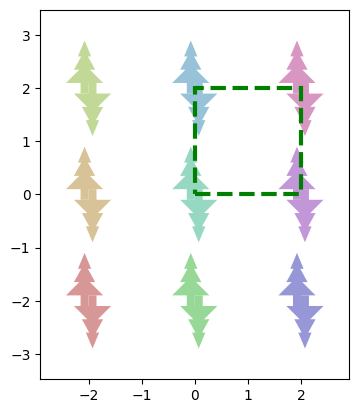

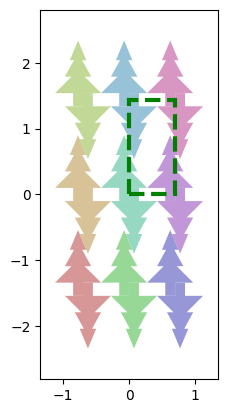

In [2]:
dimer = pack_dimer.create_dimer()
sol = kgs.SolutionCollectionLattice(xyt=dimer[None], h=cp.array([[2.,2.,np.pi/2]], dtype=kgs.dtype_cp), do_snap=False)
pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
print(pack_cost.CollisionCostOverlappingArea().compute_cost_ref(sol)[0].get())
print(pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get())
X=1/kgs.just_over_one
sol.xyt[0,:,:2]*=X
print(pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get())
sol.xyt[0,:,:2]/=X
sol.xyt[0,:,:2]/=X
print(pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get())
pack_dimer.snap_cell(sol, skip_assert=False)
pack_vis_sol.pack_vis_sol(sol, solution_idx=0)

In [3]:
import tqdm
importlib.reload(pack_dimer)
dimer = pack_dimer.create_dimer()
rot_tree_vals = cp.array(np.arange(0, np.pi/2*kgs.just_over_one, np.pi/20000), dtype=kgs.dtype_cp)
rot_cell_vals = cp.array(np.arange(np.pi/4, np.pi/2*kgs.just_over_one, np.pi/40), dtype=kgs.dtype_cp)
res_area = np.zeros((len(rot_tree_vals), len(rot_cell_vals)))
res_aspect_ratio = np.zeros((len(rot_tree_vals), len(rot_cell_vals)))
sol_base = kgs.SolutionCollectionLattice(xyt=dimer[None], h=cp.array([[3.,3.,np.pi/2]], dtype=kgs.dtype_cp), do_snap=False)
sol_base.xyt = cp.tile(sol_base.xyt[0], (len(rot_tree_vals),1,1))
sol_base.h = cp.tile(sol_base.h[0], (len(rot_tree_vals),1))
sol_base.rotate(rot_tree_vals)
sol_base.check_constraints()
for j, rot_cell in enumerate(tqdm.tqdm(rot_cell_vals)):
    sol = copy.deepcopy(sol_base)
    sol.h[:,2] = rot_cell        
    pack_dimer.snap_cell(sol, skip_assert=True)
    res_area[:,j] = pack_cost.AreaCost().compute_cost_allocate(sol)[0].get()
    res_aspect_ratio[:,j] = (sol.h[:,0]/(sol.h[:,1]*np.sin(sol.h[:,2]))).get()   
        


100%|██████████| 11/11 [00:00<00:00, 28.21it/s]


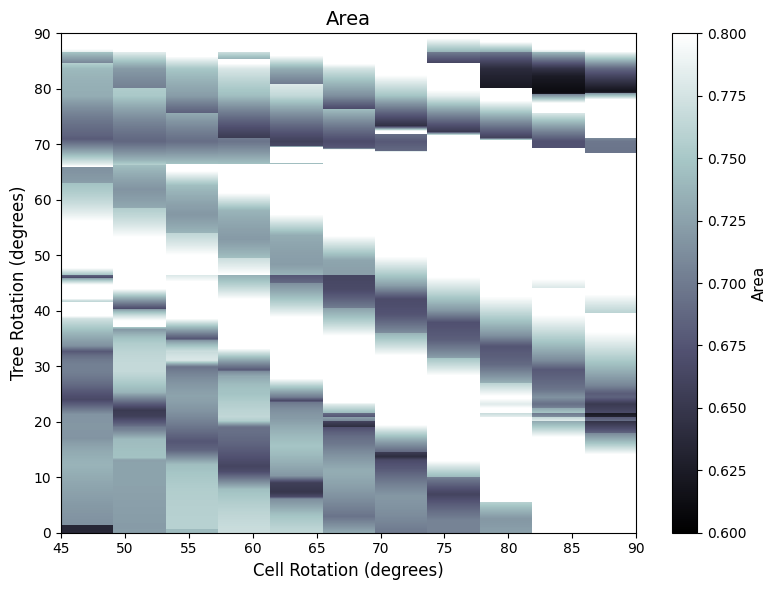

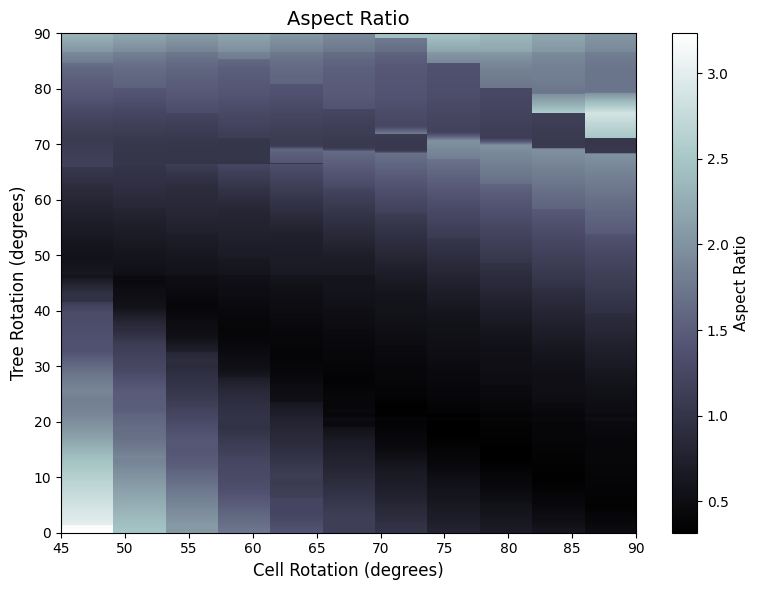

<Axes: title={'center': 'Aspect Ratio'}, xlabel='Cell Rotation (degrees)', ylabel='Tree Rotation (degrees)'>

In [4]:
import matplotlib.pyplot as plt
def plot_rotation_heatmap(data, rot_tree_vals, rot_cell_vals, title, cbar_label, clim=None):
    """Plot a heatmap of rotation analysis results."""
    # Convert radians to degrees for axis labels
    rot_tree_degrees = np.degrees(rot_tree_vals.get())
    rot_cell_degrees = np.degrees(rot_cell_vals.get())
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    im = ax.imshow(data, origin='lower', aspect='auto', cmap='bone',
                   extent=[rot_cell_degrees[0], rot_cell_degrees[-1], 
                          rot_tree_degrees[0], rot_tree_degrees[-1]], interpolation='none')
    ax.set_xlabel('Cell Rotation (degrees)', fontsize=12)
    ax.set_ylabel('Tree Rotation (degrees)', fontsize=12)
    ax.set_title(title, fontsize=14)
    if clim is not None:
        im.set_clim(*clim)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label, fontsize=11)
    
    plt.tight_layout()    
    plt.show()

    return ax

# Create two separate figures
ax = plot_rotation_heatmap(res_area, rot_tree_vals, rot_cell_vals, 
                      'Area', 'Area', clim=(0.6,0.8))


plot_rotation_heatmap(res_aspect_ratio, rot_tree_vals, rot_cell_vals, 
                      'Aspect Ratio', 'Aspect Ratio')

In [5]:
import tqdm
import pack_ga
importlib.reload(pack_dimer)
dimer = pack_dimer.create_dimer()
def relax_sol(sol, legalize=True):
    relaxer = pack_ga.GA().fine_relaxers[0]
    relaxer.cost.costs.pop(1)
    #relaxer.plot_interval = None
    relaxer.n_iterations*=50
    relaxer.max_step = 1e-4
    #pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
    #plt.pause(3)
    sol = relaxer.run_simulation(sol)
    if legalize:
        for _ in range(10):
            print(_)
            relaxer.cost.costs[0].scaling *= 0.5
            sol = relaxer.run_simulation(sol)
    return sol
rot_tree_vals = cp.array(np.arange(0, np.pi/2*kgs.just_over_one, np.pi/2000), dtype=kgs.dtype_cp)
sol_base = kgs.SolutionCollectionLatticeRectangle(xyt=dimer[None], h=cp.array([[3.,3.]], dtype=kgs.dtype_cp), do_snap=False)
sol_base.xyt = cp.tile(sol_base.xyt[0], (len(rot_tree_vals),1,1))
sol_base.h = cp.tile(sol_base.h[0], (len(rot_tree_vals),1))
sol_base.rotate(rot_tree_vals)
sol_base.check_constraints()       
sol = copy.deepcopy(sol_base)
pack_dimer.snap_cell(sol, skip_assert=False)
res_area2 = pack_cost.AreaCost().compute_cost_allocate(sol)[0].get()
res_aspect_ratio2 = (sol.h[:,0]/sol.h[:,1]).get()   
#pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
sol_r = relax_sol(copy.deepcopy(sol))
res_area3 = pack_cost.AreaCost().compute_cost_allocate(sol_r)[0].get()
res_aspect_ratio3 = (sol_r.h[:,0]/sol_r.h[:,1]).get()


stop final relax at some point


/packing/code/analysis/../core/pack_dynamics.py:59: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:90: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


0
1
2
3
4
5
6
7
8
9


In [6]:
kgs.profiling=False
sol_p = kgs.dill_load(kgs.code_dir + '/../res/packings.pickle')
sol_p.xyt = sol_p.xyt.astype(kgs.dtype_cp)
sol_p.h = sol_p.h.astype(kgs.dtype_cp)
sol_p.aspect_ratios = sol_p.aspect_ratios.astype(kgs.dtype_cp)
sol_p = relax_sol(sol_p)

res_area4 = pack_cost.AreaCost().compute_cost_allocate(sol_p)[0].get()
res_aspect_ratio4 = sol_p.aspect_ratios.get()

0
1
2
3
4
5
6
7
8
9


(1001,)


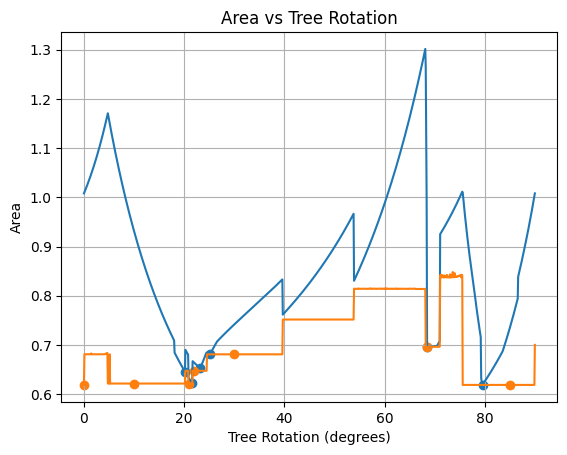

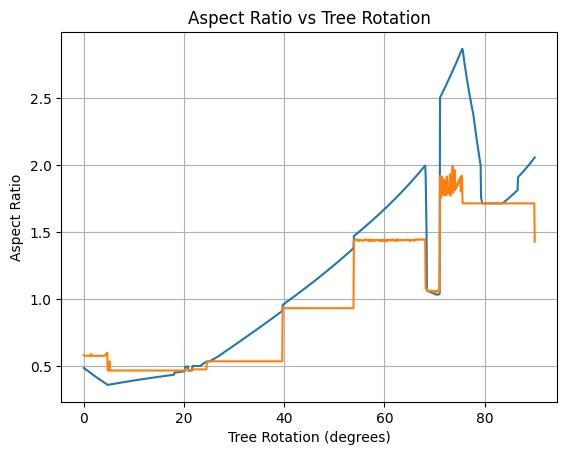

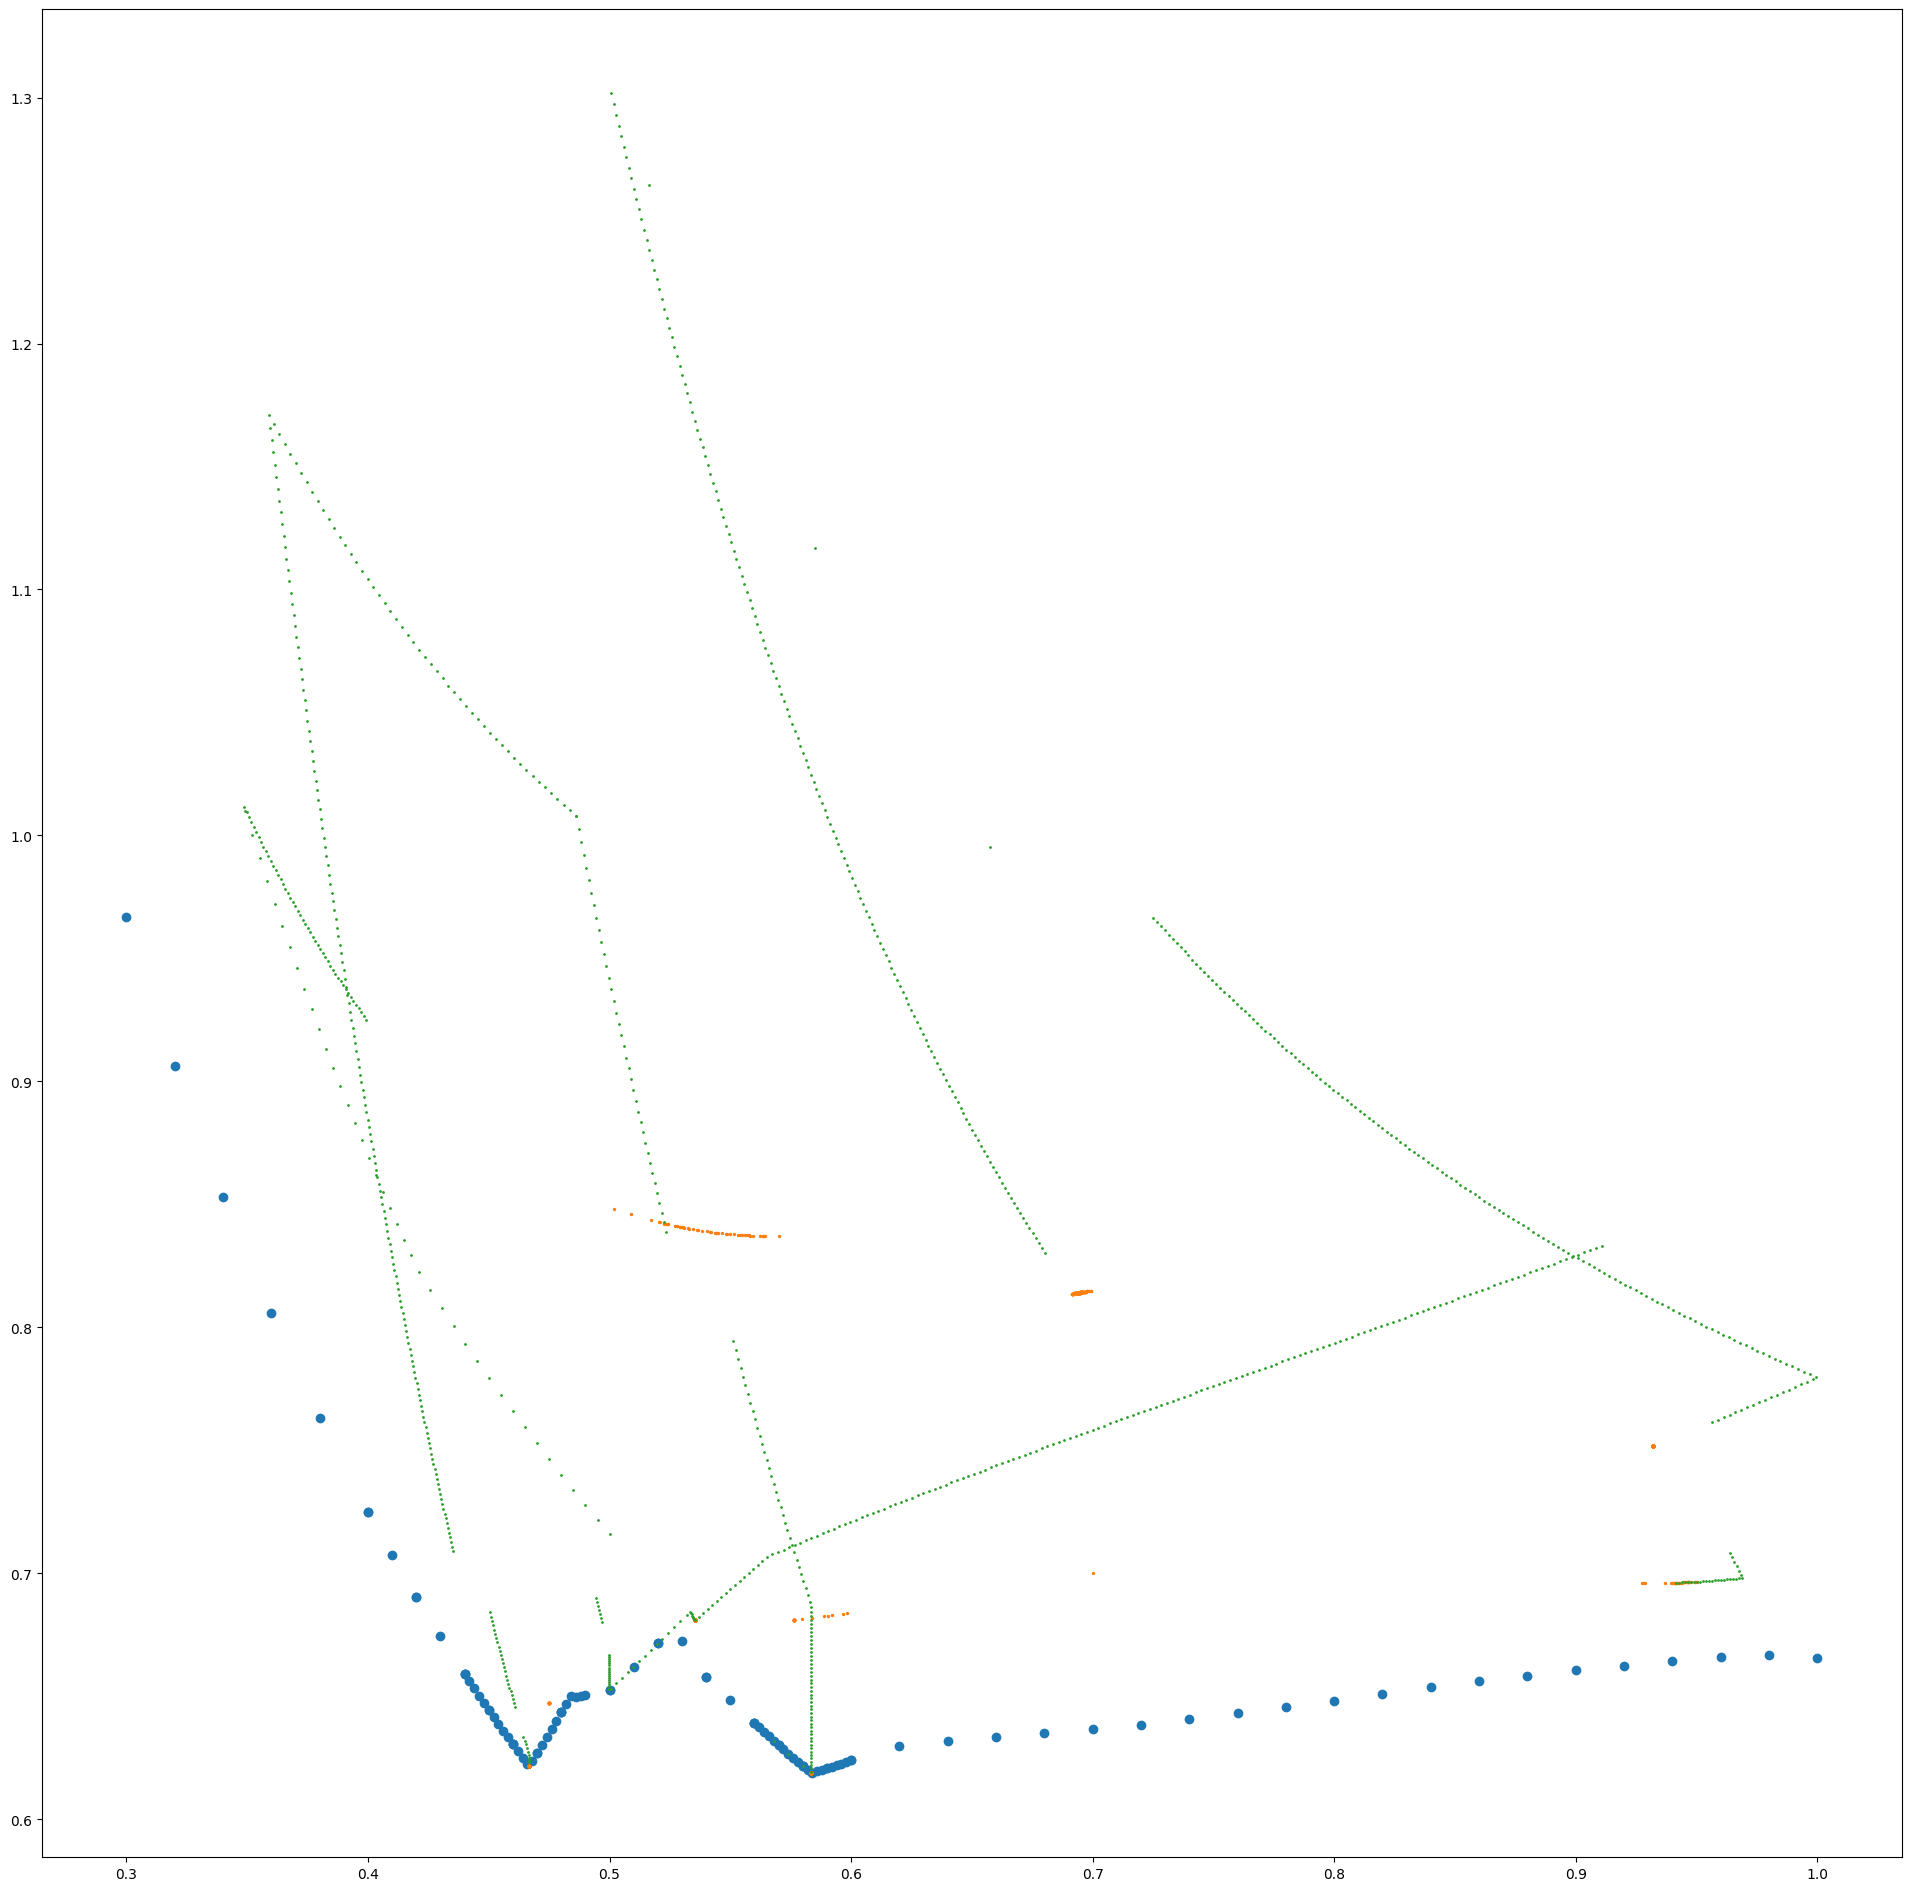

In [7]:
import mplcursors

fig1, ax1 = plt.subplots()
line1 = ax1.plot(np.degrees(rot_tree_vals.get()), res_area2)
ax1.plot(np.degrees(rot_tree_vals.get()), res_area3)
ax1.grid(True)
ax1.set_xlabel('Tree Rotation (degrees)')
ax1.set_ylabel('Area')
ax1.set_title('Area vs Tree Rotation')
mplcursors.cursor(line1, hover=True)

fig2, ax2 = plt.subplots()
line2 = ax2.plot(np.degrees(rot_tree_vals.get()), res_aspect_ratio2)
ax2.plot(np.degrees(rot_tree_vals.get()), res_aspect_ratio3)
ax2.grid(True)
ax2.set_xlabel('Tree Rotation (degrees)')
ax2.set_ylabel('Aspect Ratio')
ax2.set_title('Aspect Ratio vs Tree Rotation')
mplcursors.cursor(line2, hover=True)

from scipy.signal import find_peaks
a,b = find_peaks(-res_area2, height=-1000)
b=-b['peak_heights']
sel = b<0.7
a=a[sel]
rads_min = rot_tree_vals[a]
ax1.scatter(np.degrees(rads_min.get()),res_area2[a])
solx = copy.deepcopy(sol)
solx.xyt = solx.xyt[a]
solx.h = solx.h[a]
names = [f'{np.degrees(r.get()):.4f}' for r in rads_min]

print(res_area3.shape)
deg_vals = np.array([0., 10., 21., 22., 30., 68.5, 85.])
rad_vals = np.radians(deg_vals)
# find indices closest to rad_vals
a = [np.argmin(np.abs(rot_tree_vals.get() - rv)) for rv in rad_vals]
rads_min = rot_tree_vals[a]
ax1.scatter(np.degrees(rads_min.get()),res_area3[a])
solx.xyt = cp.concatenate((solx.xyt,sol_r.xyt[a]))
solx.h = cp.concatenate((solx.h,sol_r.h[a]))
names = names+[f'{np.degrees(r.get()):.4f}rel' for r in rads_min]

solx.xyt = cp.concatenate((solx.xyt,sol_p.xyt))
h_new = cp.array([ [sol_p.h[i,0], sol_p.aspect_ratios[i]*sol_p.h[i,0] ] for i in range(sol_p.N_solutions)], dtype=kgs.dtype_cp)
solx.h = cp.concatenate((solx.h,h_new))
solx.check_constraints()
names = names+[f'ga' for _ in range(sol_p.N_solutions)]

plt.figure(figsize=(24,24))
plt.scatter(np.minimum(res_aspect_ratio4, 1/res_aspect_ratio4), res_area4, label='Prepped')
plt.scatter(np.minimum(res_aspect_ratio3, 1/res_aspect_ratio3), res_area3, 2., label='After Relaxation')
plt.scatter(np.minimum(res_aspect_ratio2, 1/res_aspect_ratio2), res_area2, 1., label='Before Relaxation')


In [8]:
importlib.reload(pack_dimer)
best_trees_list = []
kgs.profiling=False
solutions_to_process = []
for i in range(solx.N_solutions):    
    this_sol = copy.deepcopy(solx)
    this_sol.xyt = this_sol.xyt[i:i+1]
    this_sol.h = this_sol.h[i:i+1]
    #plt.figure(figsize=(6,6))
    #pack_vis_sol.pack_vis_sol(this_sol)
    #plt.title(f'{names[i]}, Area: {pack_cost.AreaCost().compute_cost_allocate(this_sol)[0].get()[0]:.4f}, Aspect Ratio: {this_sol.h[0,0]/this_sol.h[0,1]:.4f}')
    #plt.show()
    solutions_to_process.append(this_sol)

len(solutions_to_process)


115

In [9]:
%%time
pack_dimer.try_tilings(solutions_to_process[0]);


CPU times: user 17.4 s, sys: 23 ms, total: 17.4 s
Wall time: 17.4 s


In [10]:
import multiprocess
multiprocess.set_start_method('spawn', force=True)
with multiprocess.Pool(processes=6) as pool:
    best_trees_list = pool.map(pack_dimer.try_tilings, solutions_to_process)

# best_trees_list=[]
# for s in solutions_to_process:
#     best_trees_list.append(pack_dimer.try_tilings(s))

vast
vast
vast
vast
vast
vast


In [11]:
import pack_io
importlib.reload(pack_io)
import pandas as pd
[sol_list_ref, scores] = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.temp_dir + '71.66.csv'))
#[sol_list_ref2, scores2] = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.temp_dir + '71.66.csv'))
#for s in sol_list_ref:
#    s.rotate(-np.pi/2)

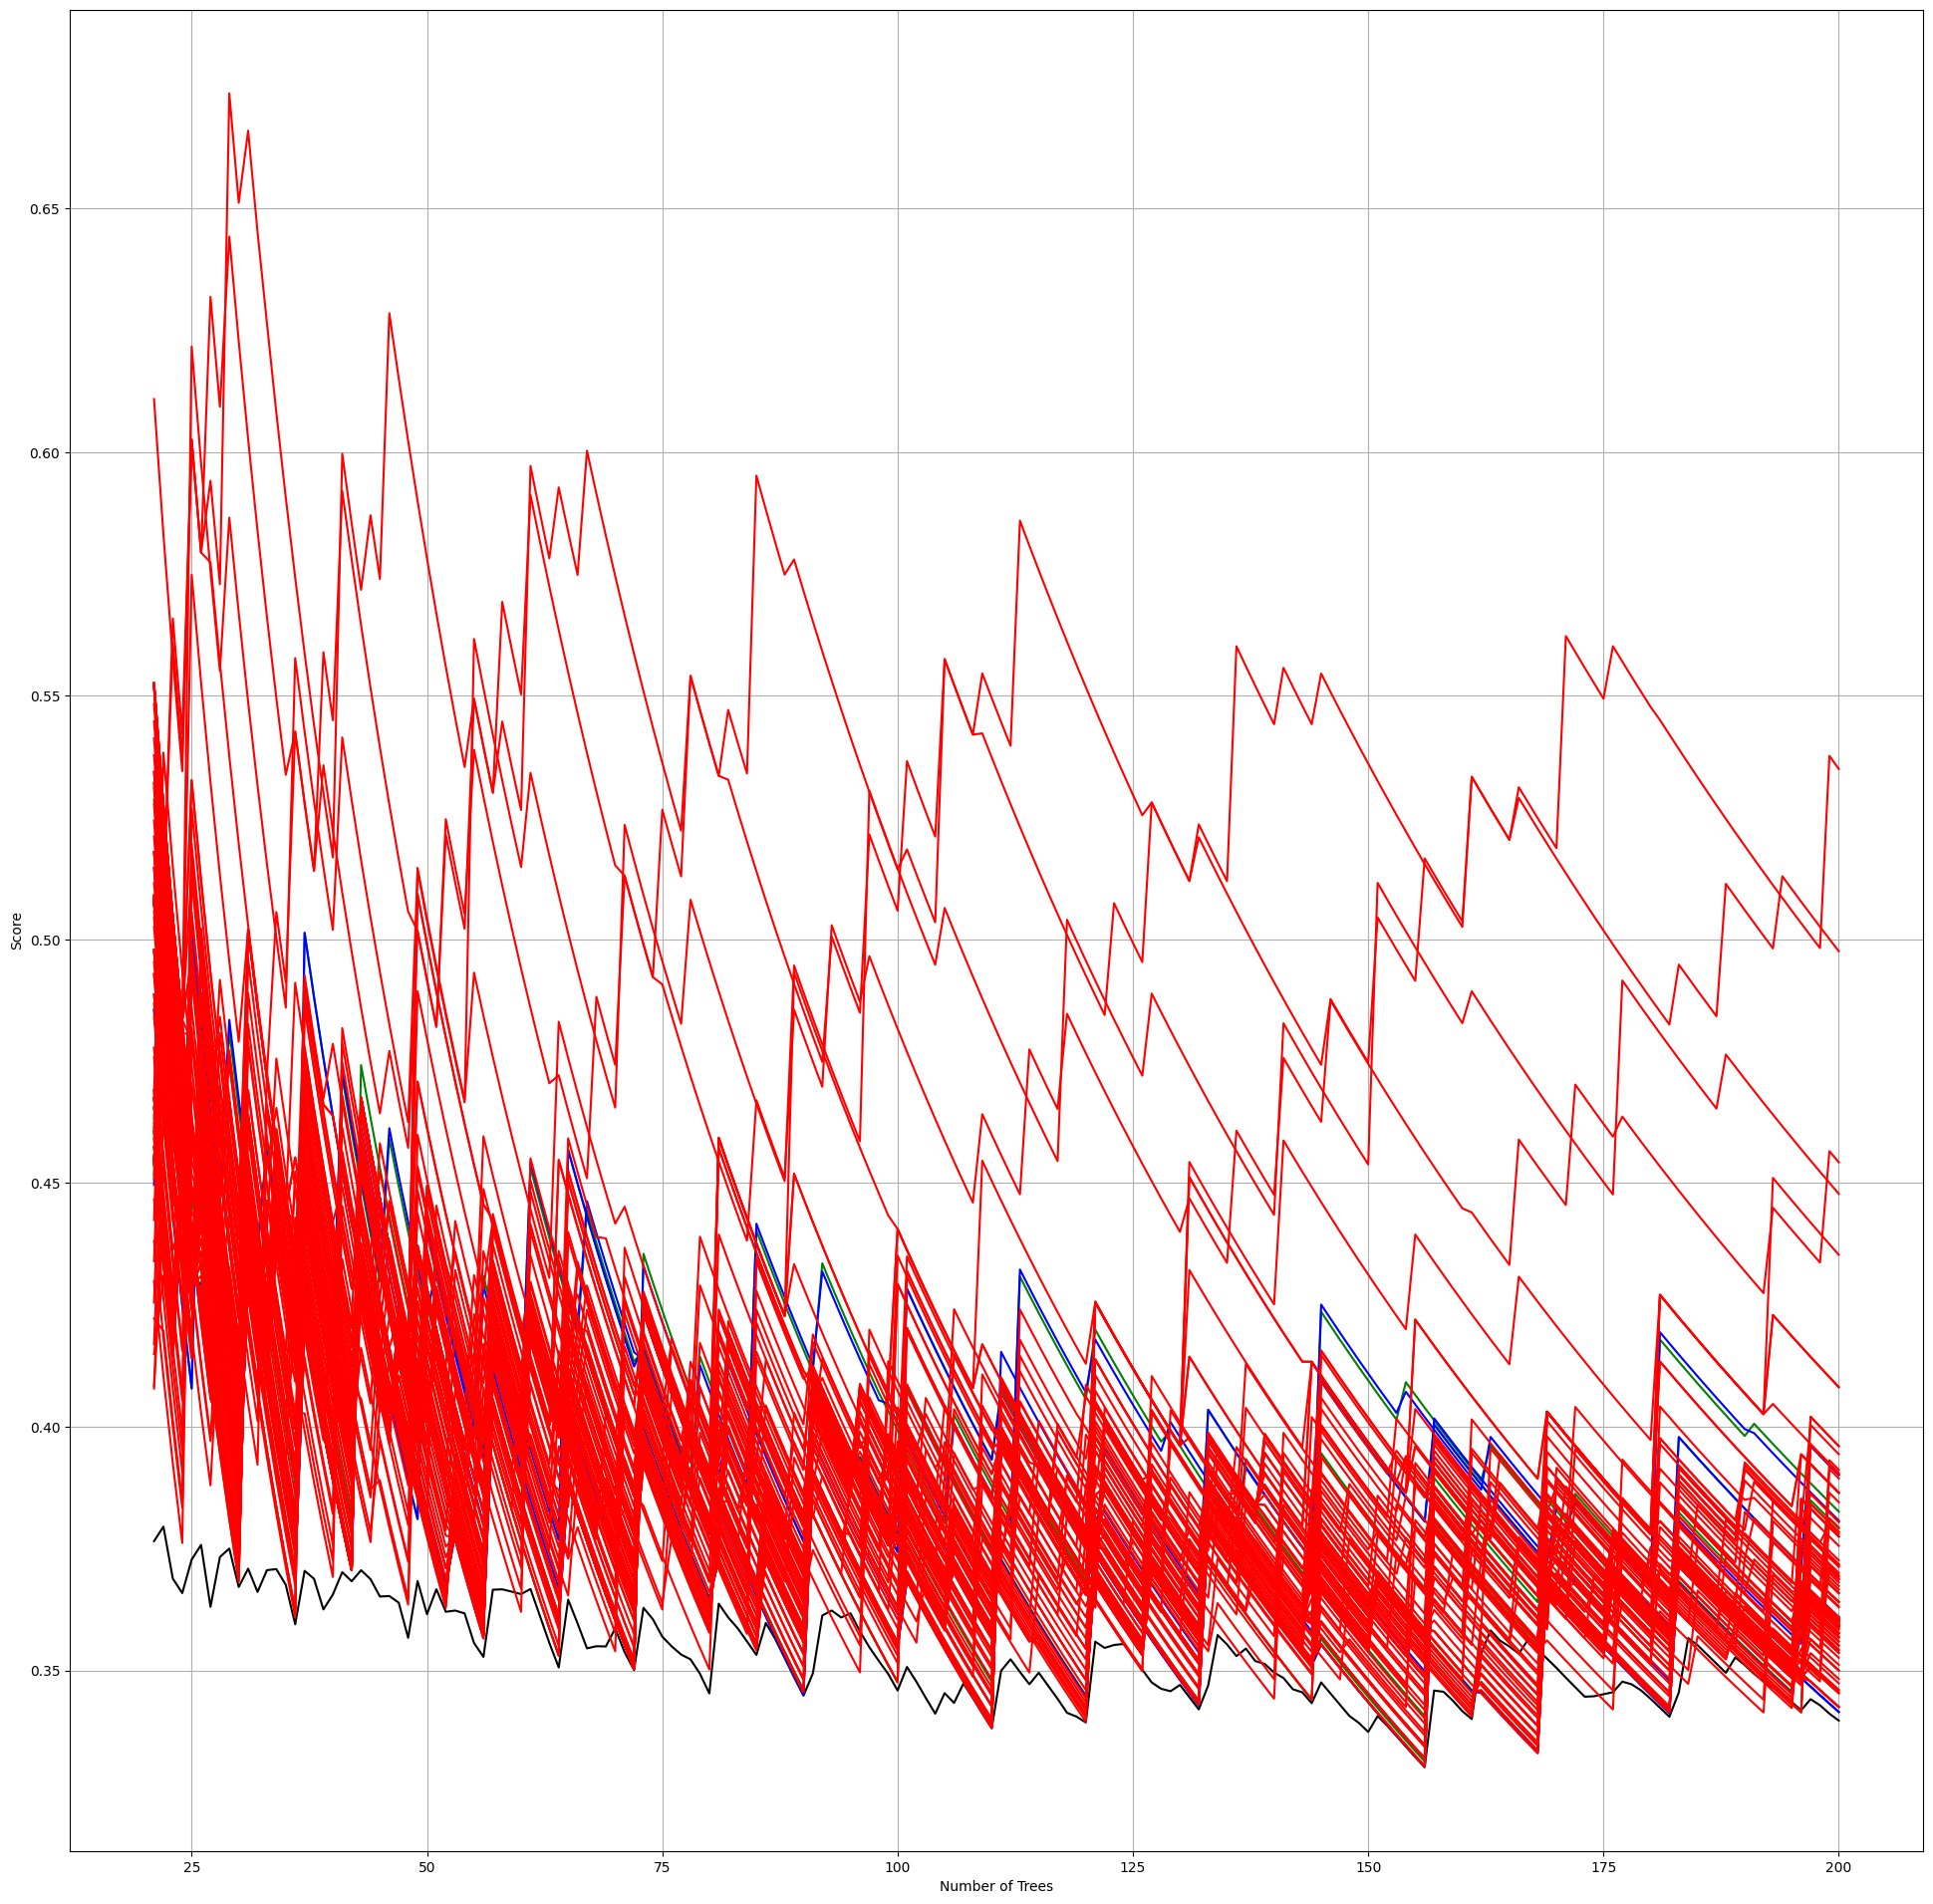

In [12]:
plt.figure(figsize=(24,24))
N_trees = np.arange(1,201)
N=20
lines = []
vals_res = np.array([np.inf]*200)
#line = plt.plot(N_trees[N:], scores[N:], 'k')
line = plt.plot(N_trees[N:], scores[N:], 'k')
lines.extend(line)
for b,n in zip(best_trees_list, names):
    this_vals = b[0]**2/N_trees
    vals_res = np.minimum(vals_res, this_vals)
    if 'rel' in n: 
        line = plt.plot(N_trees[N:], this_vals[N:], 'b')
    elif 'ga' in n:
        line = plt.plot(N_trees[N:], this_vals[N:], 'r')
    else:
        line = plt.plot(N_trees[N:], this_vals[N:], 'g')
    lines.extend(line)
plt.grid(True)
#plt.legend(['ref']+names)
plt.xlabel('Number of Trees')
plt.ylabel('Score')

# Add interactive cursor for all lines
mplcursors.cursor(lines, hover=True)

In [13]:
overall_best = []
overall_best_score = []
for i_tree in range(200):
    best_id = np.argmin([b[0][i_tree] for b in best_trees_list])
    best_sol = best_trees_list[best_id][1][i_tree]
    overall_best.append(best_sol)
    overall_best_score.append( (best_sol.h[0,0]**2/best_sol.N_trees).get())

In [14]:
import pack_io
import boolean_line_search
import pack_metric
importlib.reload(boolean_line_search)
importlib.reload(pack_io)
importlib.reload(pack_metric)
#x=pack_io.solution_list_to_dataframe(overall_best)
#x
#x.to_csv(kgs.temp_dir + 'submission.csv', index=False)

<module 'pack_metric' from '/packing/code/analysis/../core/pack_metric.py'>

In [15]:
from tqdm import tqdm
import multiprocess

multiprocess.set_start_method('spawn', force=True)

def do_one(sol):
    import pack_io
    import kaggle_support as kgs
    kgs.set_float32(True)
    return pack_io.legalize(sol)

with multiprocess.Pool(processes=5) as pool:
    overall_best_legalized = list(
        tqdm(
            pool.imap(do_one, overall_best),
            total=len(overall_best),
            desc="Legalizing"
        )
    )
#kgs.dill_save(kgs.temp_dir + 'tess_legalized.pickle', overall_best_legalized)
kgs.dill_save(kgs.code_dir + '../res/tess_legalized.pickle', pop)
overall_best_legalized = kgs.dill_load(kgs.code_dir + '../res/tess_legalized.pickle')
overall_best_legalized_score = [(x.h[0,0]**2/x.N_trees).get() for x in overall_best_legalized]

Legalizing:   0%|          | 0/200 [00:00<?, ?it/s]

vast
vast
vast
vast
vast


Legalizing: 100%|██████████| 200/200 [00:02<00:00, 66.84it/s] 


(np.float64(71.65614508068765),
 np.float32(74.42848),
 np.float64(71.45094159689792))

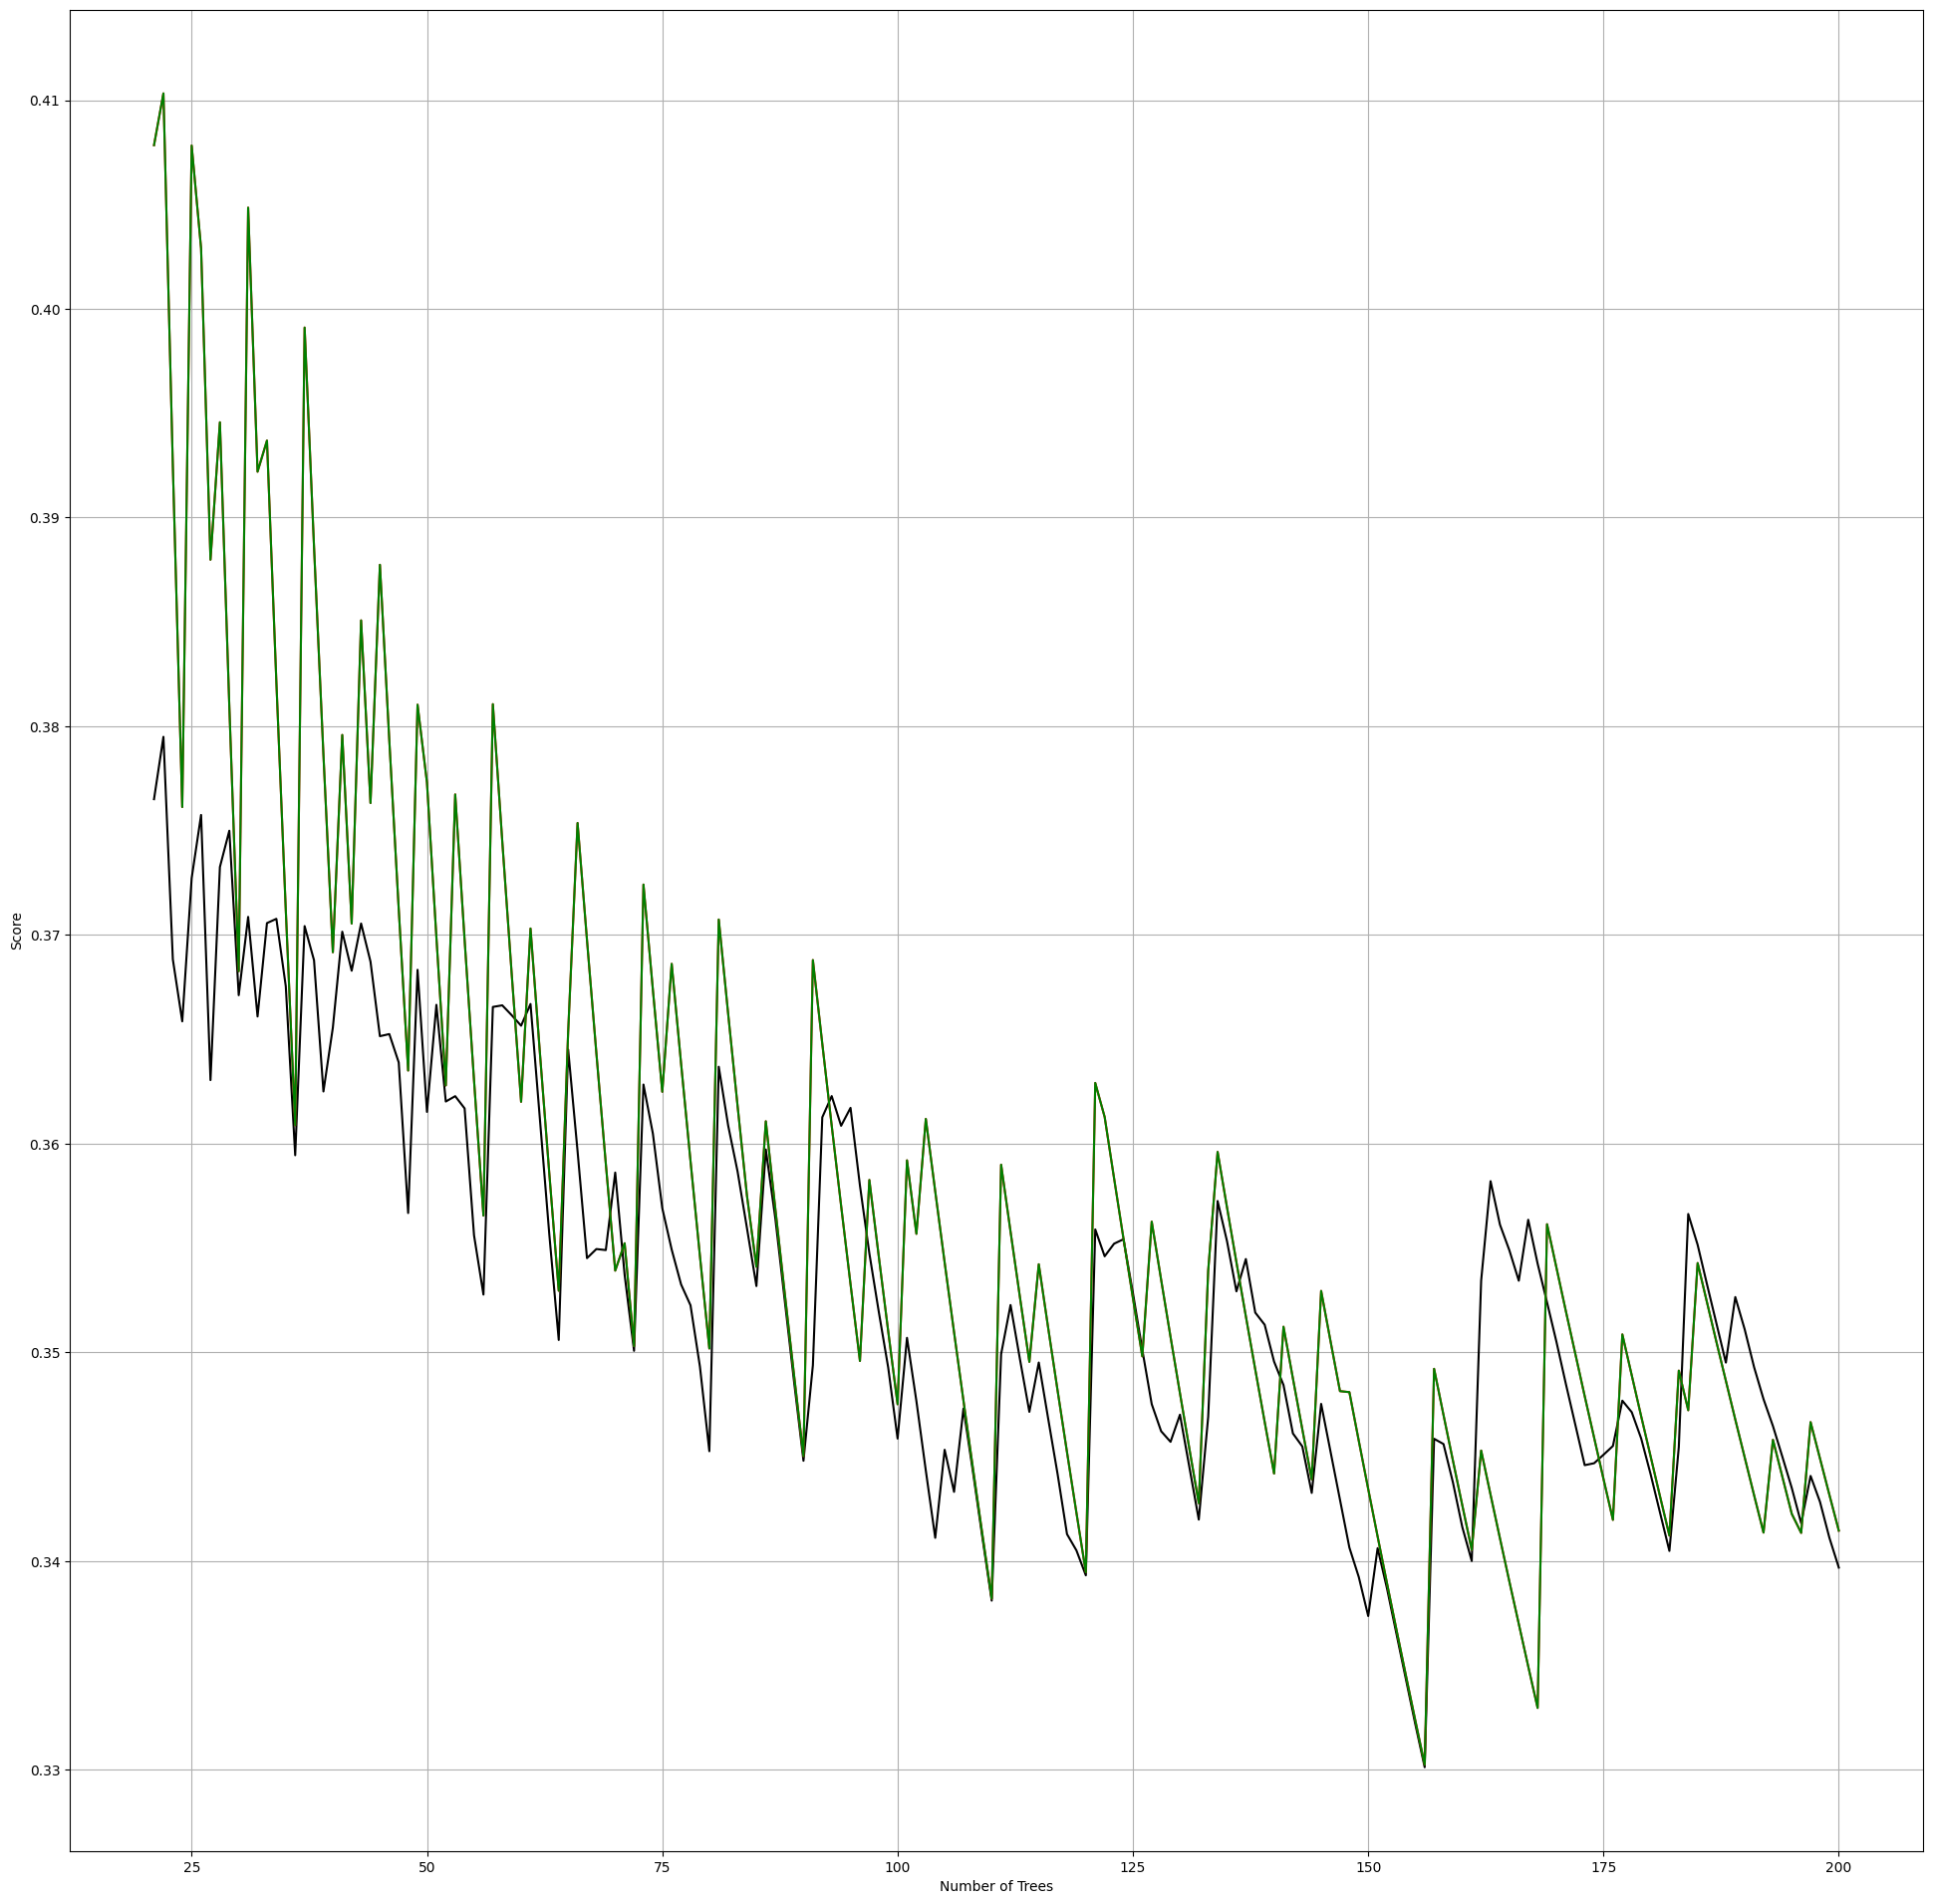

In [16]:
plt.figure(figsize=(24,24))
N_trees = np.arange(1,201)
N=20
lines = []
vals_res = np.array([np.inf]*200)
line = plt.plot(N_trees[N:], scores[N:], 'k')
lines.extend(line)
line = plt.plot(N_trees[N:], overall_best_score[N:], 'r')
lines.extend(line)   
line = plt.plot(N_trees[N:], overall_best_legalized_score[N:], 'g')
lines.extend(line)   
plt.grid(True)
#plt.legend(['ref']+names)
plt.xlabel('Number of Trees')
plt.ylabel('Score')

# Add interactive cursor for all lines
mplcursors.cursor(lines, hover=True)

np.sum(scores), np.sum(overall_best_legalized_score), np.sum(np.minimum(scores, overall_best_legalized_score))

In [17]:
kgs.dill_save(kgs.code_dir + '/../res/opt_practice.pickle', overall_best[55])
kgs.dill_save(kgs.code_dir + '/../res/opt_practice2.pickle', sol_list_ref[55])


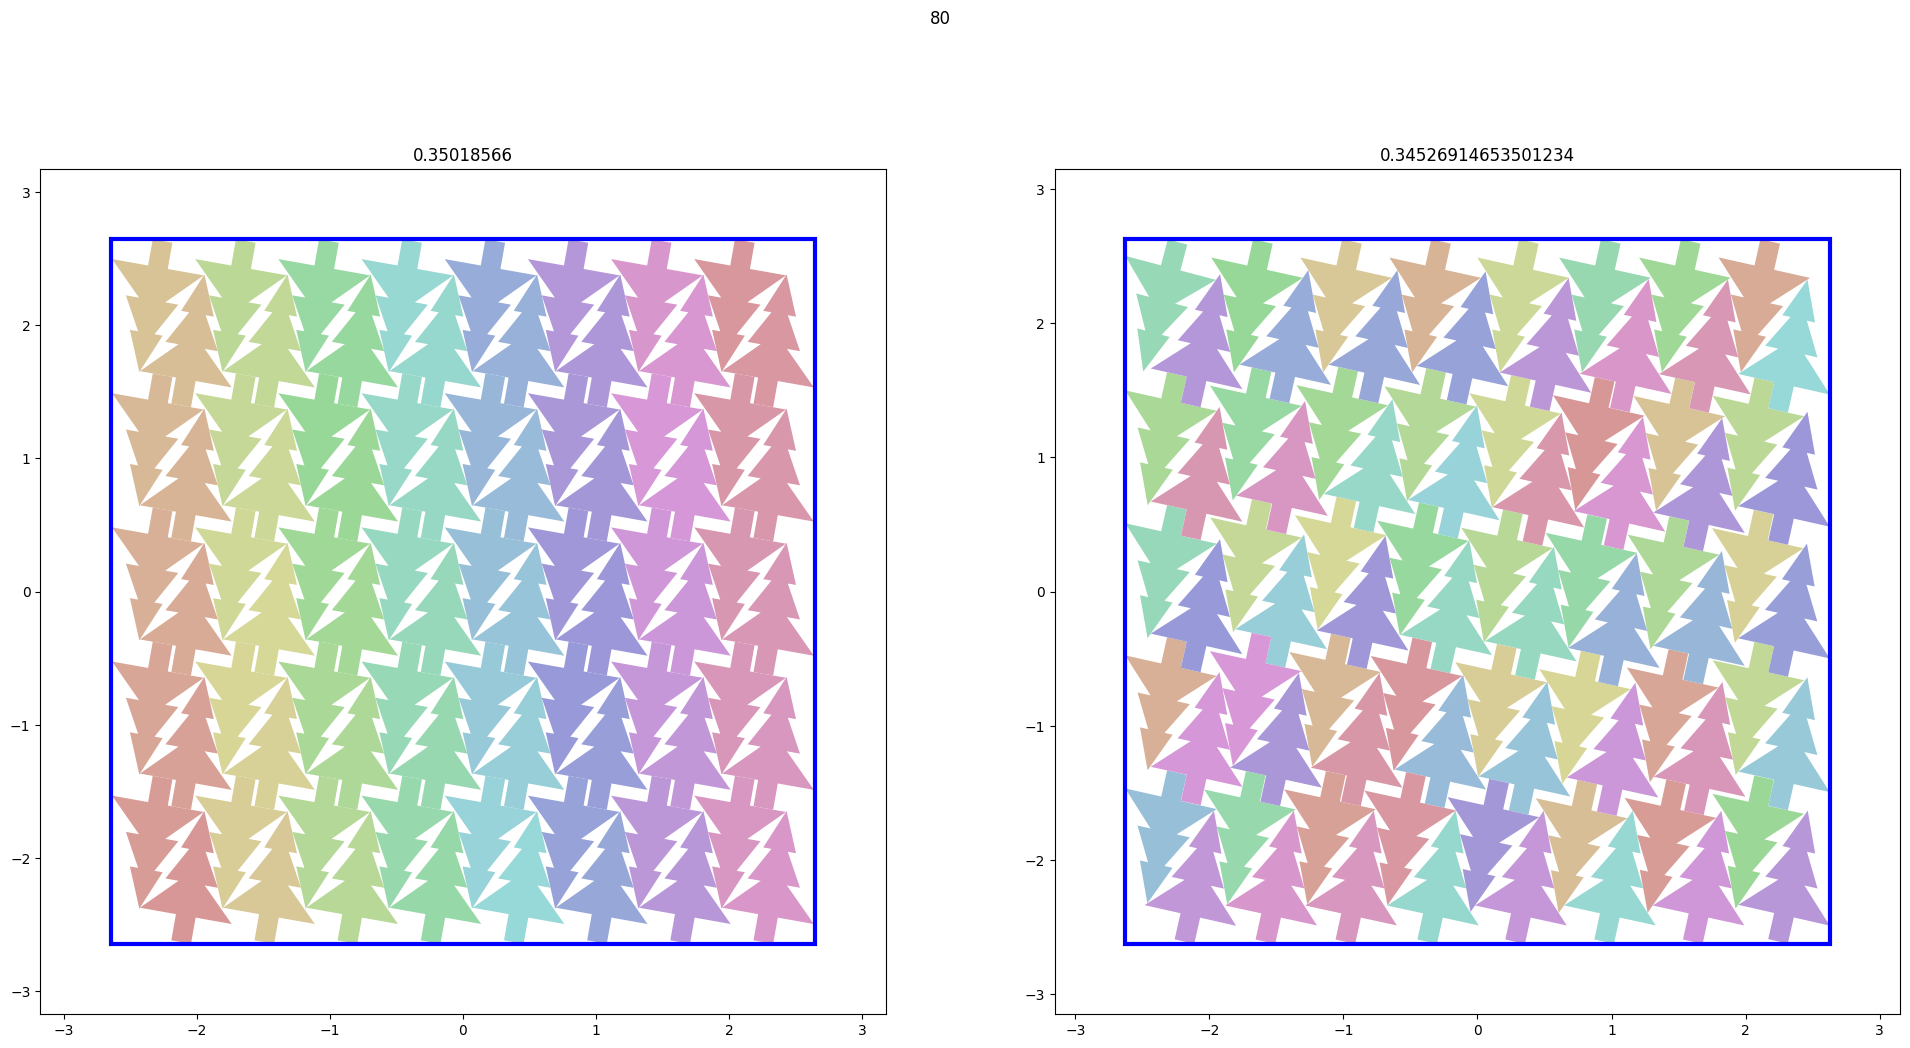

In [19]:
for N in [80]:
    _,ax = plt.subplots(1,2,figsize=(24,12))
    pack_vis_sol.pack_vis_sol(overall_best_legalized[N-1], solution_idx=0, ax=ax[0])
    plt.sca(ax[0])
    plt.title(overall_best_legalized[N-1].h[0,0]**2/overall_best[N-1].N_trees)
    sol2 = copy.deepcopy(sol_list_ref[N-1])
    sol2.rotate(cp.array([-np.pi/2]))
    sol2.snap()
    #sol2.xyt = cp.concatenate((overall_best[N-1].xyt, sol2.xyt), axis=1)
    pack_vis_sol.pack_vis_sol(sol2, solution_idx=0, ax=ax[1])
    plt.sca(ax[1])
    plt.title(sol_list_ref[N-1].h[0,0]**2/overall_best[N-1].N_trees)
    plt.suptitle(N)